In [1]:
!pip install opendatasets

In [2]:
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader
import opendatasets as od
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from numba import cuda
from torch.utils.data import Dataset,DataLoader,Subset,random_split


In [3]:
od.download('https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pekpuch
Your Kaggle Key: ··········


100%|██████████| 1.08G/1.08G [00:13<00:00, 87.8MB/s]


In [4]:
from torchvision import transforms
from torchvision import datasets

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform, target_transform=None):
      self.img_labels = os.listdir(path = img_dir)
      self.labels_map = {}
      it = 0
      for i in self.img_labels:
        self.labels_map[i] = it
        it+=1
      self.labels = []
      self.img_list = []
      for i in self.img_labels:
        img_dir_tmp = img_dir + '/' + i + '/'
        for j in os.listdir(path = img_dir_tmp):
          self.img_list.append(img_dir_tmp+j)
          self.labels.append(i)
      self.labels_final = []
      for i in self.labels:
        self.labels_final.append(self.labels_map[i])
      self.transform = transform
      self.target_transform = target_transform
    def __len__(self):
      return len(self.img_list)
    def __getitem__(self, idx):
      img_path = self.img_list[idx]
      image = Image.open(img_path).convert('RGB')
      label = self.labels_final[idx]
      w, h = image.size
      if self.transform:
        image = self.transform(image)
      return image, label

transforms = v2.Compose([
      v2.RandomResizedCrop(size=(224, 224), antialias=True),
      transforms.ToTensor(),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

In [5]:
myDataset = CustomImageDataset (img_dir = '/content/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset', transform = transforms)

In [6]:
class Net(nn.Module):
  def __init__(self, labels_count = len(myDataset.labels_map)):
    super(Net, self).__init__()

    # Сверточный слой 1
    # Этот слой применит 32 сверточных фильтра размером 3x3 на входное изображение.
    # Шаг равен 1, что означает, что фильтр будет двигаться на 1 пиксель за раз.
    # Заполнение равно 1, чтобы сохранить пространственные размеры (высоту и ширину) неизменными после операции свертки.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

    # Нормализация пакетов слоя 1
    # Этот слой нормализует активации нейронов в предыдущем слое, что может помочь ускорить обучение и уменьшить чувствительность к инициализации сети.
    self.batch_norm1 = nn.BatchNorm2d(32)

    # Слой максимального пулинга 1
    # Этот слой уменьшит пространственные размеры (высоту и ширину) входного объема, выбрав максимальное значение в каждом патче 2x2.
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Сверточный слой 2
    # Этот слой применит 64 сверточных фильтра размером 3x3 на выход предыдущего слоя.
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    # Нормализация пакетов слоя 2
    self.batch_norm2 = nn.BatchNorm2d(64)

    # Слой максимального пулинга 2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Сверточный слой 3
    # Этот слой применит 128 сверточных фильтров размером 3x3 на выход предыдущего слоя.
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

    # Нормализация пакетов слоя 3
    self.batch_norm3 = nn.BatchNorm2d(128)

    # Слой максимального пулинга 3
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Сверточный слой 4
    # Этот слой применит 256 сверточных фильтров размером 3x3 на выход предыдущего слоя.
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

    # Нормализация пакетов слоя 4
    self.batch_norm4 = nn.BatchNorm2d(256)

    # Слой максимального пулинга 4
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Полносвязный слой 1
    # Этот слой соединит каждый нейрон в предыдущем слое со всеми нейронами в этом слое.
    # Он примет сплошной выход из предыдущего слоя (256 * 14 * 14) и выдаст 512 значений.
    self.fc1 = nn.Linear(256 * 14 * 14, 512)

    # Полносвязный слой 2
    # Этот слой примет выход из предыдущего слоя (512) и выдаст число значений, равное числу меток.
    self.fc2 = nn.Linear(512, labels_count)

  def forward(self, x):
    # Применить первый набор операций свертки, нормализации пакетов и максимального пулинга, за которыми следует функция активации ReLU.
    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
    x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))

    # Преобразовать выход из предыдущего слоя в единичный вектор.
    x = x.view(-1, 256 * 14 * 14)

    # Применить первый полносвязный слой, за которым следует функция активации ReLU.
    x = F.relu(self.fc1(x))

    # Применить второй полносвязный слой. Это выдаст вектор вероятностей для каждой метки.
    x = self.fc2(x)

    # Вернуть выход.
    return x


In [7]:
dataset_size = len(myDataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(myDataset, [train_size, val_size]) # Разделение Train датасета на Val и Train

In [8]:
learning_rate = 0.001
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=myDataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay = 0.01) # w = w - α * ∇L
criterion = nn.CrossEntropyLoss() # L = -1/N * Σ (y_i * log(p_i))

In [11]:
def model_training(model,train_loader,optimizer,criterion):
  running_loss = 0.0
  model.train()
  for inputs,labels in train_loader:

    # обнуление градиентов
    optimizer.zero_grad()
    inputs,labels = inputs.to(device) , labels.to(device)

    # проход батча через слои нейронной сети
    out = model(inputs)

    # подсчет потерь
    loss = criterion(out,labels)

    # вычисление градиентов
    loss.backward()

    # обновление градиентов модели в стороны минимизации потерь
    optimizer.step()

    # подсчет потерь эпохи
    running_loss += loss.item()

  return running_loss / len(inputs)

In [12]:
def model_validating(model,val_loader,criterion):
  running_loss = 0.0
  model.eval()
  for inputs,labels in val_loader:

    # отключение вычислений градиентов
    with torch.no_grad():
      inputs,labels = inputs.to(device),labels.to(device)
      out = model(inputs)
      loss = criterion(out,labels)
      running_loss += loss.item()
  return running_loss / len(inputs)

In [13]:
num_epochs = 20
train_loss_arr = []
val_loss_arr = []
for epoch in range(num_epochs):
    train_loss = model_training(model, train_loader, optimizer, criterion)
    val_loss = model_validating(model, val_loader, criterion)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

Epoch [1/20], Train Loss: 6.1366, Val Loss: 0.8150
Epoch [2/20], Train Loss: 5.0732, Val Loss: 0.6961
Epoch [3/20], Train Loss: 4.6254, Val Loss: 0.6651
Epoch [4/20], Train Loss: 4.3580, Val Loss: 0.6351
Epoch [5/20], Train Loss: 4.0867, Val Loss: 0.5877
Epoch [6/20], Train Loss: 3.8692, Val Loss: 0.5756
Epoch [7/20], Train Loss: 3.7320, Val Loss: 0.5539
Epoch [8/20], Train Loss: 3.6290, Val Loss: 0.5620
Epoch [9/20], Train Loss: 3.4694, Val Loss: 0.5283
Epoch [10/20], Train Loss: 3.3856, Val Loss: 0.4867
Epoch [11/20], Train Loss: 3.2627, Val Loss: 0.4719
Epoch [12/20], Train Loss: 3.1830, Val Loss: 0.4661
Epoch [13/20], Train Loss: 3.1023, Val Loss: 0.4789
Epoch [14/20], Train Loss: 3.0104, Val Loss: 0.4545
Epoch [15/20], Train Loss: 2.9241, Val Loss: 0.4224
Epoch [16/20], Train Loss: 2.9128, Val Loss: 0.4340
Epoch [17/20], Train Loss: 2.8649, Val Loss: 0.4335
Epoch [18/20], Train Loss: 2.8169, Val Loss: 0.4850
Epoch [19/20], Train Loss: 2.7569, Val Loss: 0.4359
Epoch [20/20], Train 

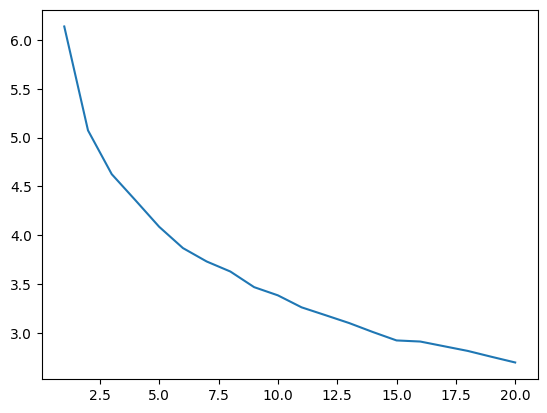

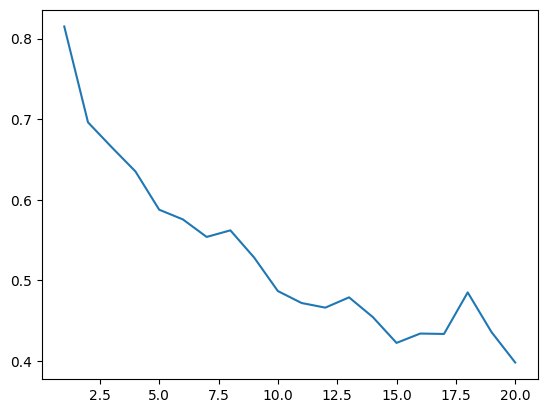

In [14]:
import matplotlib.pyplot as plt
x = list(range(1, 21))
plt.plot(x, train_loss_arr)
plt.show()
plt.plot(x, val_loss_arr)
plt.show()


In [16]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/model_v4.pth')

In [17]:
checkpoint = torch.load('/content/model_v4.pth',map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [54]:
def predict_image(model,img_path):
  with open(img_path,'rb') as f :
    img = Image.open(f).convert("RGB")
  img_tensor = transforms(img).unsqueeze(0).to(device)
  out = model(img_tensor) # прогоняем изображение через нейронную сеть
  pred_label = torch.argmax(torch.softmax(out,dim=1),dim=1) # применяем softmax и получаем класс с максимальной вероятностью
  for key,value in myDataset.labels_map.items(): # перебираем метки
    if value==pred_label: # если значение метки совпадает с предсказанной меткой, сохраняем имя класса в class_name
      class_name = key
  return pred_label,class_name

In [55]:
def test_testset(path):
  path = path+'/'
  results = []
  test_classes_names=[]
  model.eval()
  for i in os.listdir(path):
    pred_label,class_name = predict_image(model,os.path.join(path,i))
    p=i[::-1]
    _, p =p.split('_', 1)
    p=p[::-1]
    if class_name not in test_classes_names:
        test_classes_names.append(class_name)
    results.append((p, class_name))
  return results , test_classes_names

In [62]:
results,_ = test_testset('/content/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset')

In [63]:
df = pd.DataFrame(results, columns=['Expected', 'Predicted'])

df.to_csv('predictions.csv', index=False)

In [64]:
df = pd.read_csv('predictions.csv')

In [65]:
ct = pd.crosstab(df['Expected'],df['Predicted'])

ct

Predicted,abraham_grampa_simpson,apu_nahasapeemapetilon,bart_simpson,carl_carlson,charles_montgomery_burns,chief_wiggum,comic_book_guy,edna_krabappel,groundskeeper_willie,homer_simpson,...,mayor_quimby,milhouse_van_houten,moe_szyslak,ned_flanders,nelson_muntz,patty_bouvier,principal_skinner,selma_bouvier,sideshow_bob,waylon_smithers
Expected,,,,,,,,,,,,,,,,,,,,,
abraham_grampa_simpson,31,0,0,0,2,0,0,1,0,1,...,0,0,3,3,0,0,0,0,3,0
apu_nahasapeemapetilon,0,45,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
bart_simpson,0,0,19,0,2,0,0,1,0,1,...,0,1,2,2,0,0,2,1,1,0
charles_montgomery_burns,0,0,0,0,32,0,0,1,0,0,...,0,1,4,1,0,0,5,0,2,0
chief_wiggum,0,1,0,0,0,44,0,0,0,0,...,0,0,3,1,0,0,0,0,0,0
comic_book_guy,1,1,0,0,1,2,24,1,1,0,...,0,2,4,2,0,0,4,0,2,1
edna_krabappel,0,1,0,0,0,0,0,37,0,0,...,0,1,0,5,0,0,1,0,1,0
homer_simpson,2,0,0,0,1,0,0,0,0,30,...,0,0,4,5,0,0,0,0,1,0
kent_brockman,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
true_labels = df['Expected'].values
pred_labels = df['Predicted'].values
cm_array = confusion_matrix(true_labels, pred_labels)

In [68]:
precision = cm_array.diagonal() / cm_array.sum(axis=0)
recall = cm_array.diagonal() / cm_array.sum(axis=1)

<ipython-input-68-0deccd5810ff>:2: RuntimeWarning: invalid value encountered in divide
  recall = cm_array.diagonal() / cm_array.sum(axis=1)


In [69]:
pres_sum = 0
rec_sum = 0
f1_sum = 0
pres_count = 0
rec_count = 0
f1_count = 0

for i in range(len(recall)):
  if round(precision[i],2)!=0:
    print(f"Class {ct.columns[i]}: Precision={round(precision[i],2)}, Recall={round(recall[i],2)} f1-score = {round(2 * ((recall[i]*precision[i])/(recall[i]+precision[i])),2)}")
    pres_sum += round(precision[i],2)
    rec_sum += round(recall[i],2)
    f1_sum += round(2 * ((recall[i]*precision[i])/(recall[i]+precision[i])),2)
    pres_count += 1
    rec_count += 1
    f1_count += 1


Class abraham_grampa_simpson: Precision=0.89, Recall=0.65 f1-score = 0.75
Class apu_nahasapeemapetilon: Precision=0.85, Recall=0.9 f1-score = 0.87
Class bart_simpson: Precision=0.73, Recall=0.38 f1-score = 0.5
Class charles_montgomery_burns: Precision=0.74, Recall=0.67 f1-score = 0.7
Class chief_wiggum: Precision=0.85, Recall=0.88 f1-score = 0.86
Class comic_book_guy: Precision=0.96, Recall=0.49 f1-score = 0.65
Class edna_krabappel: Precision=0.86, Recall=0.74 f1-score = 0.8
Class homer_simpson: Precision=0.71, Recall=0.6 f1-score = 0.65
Class kent_brockman: Precision=0.78, Recall=0.78 f1-score = 0.78
Class krusty_the_clown: Precision=0.72, Recall=0.82 f1-score = 0.77
Class lenny_leonard: Precision=0.87, Recall=0.52 f1-score = 0.65
Class lisa_simpson: Precision=0.54, Recall=0.56 f1-score = 0.55
Class marge_simpson: Precision=0.69, Recall=0.84 f1-score = 0.76
Class mayor_quimby: Precision=0.96, Recall=0.5 f1-score = 0.66
Class milhouse_van_houten: Precision=0.78, Recall=0.73 f1-score = 

In [70]:
import numpy as np

print(f"average Precision={round(pres_sum/pres_count, 2)} average Recall={round(rec_sum/rec_count, 2)} average F1-score = { round(f1_sum/f1_count, 2)}")

average Precision=0.76 average Recall=0.71 average F1-score = 0.71
